# USEFUL NOTES


*   Execute all cells until <font color='cyan'>TRAINING EVALUATION </font>(this one too)
*   <font color='cyan'>Confusion matrix</font> concerns the <font color='cyan'>VALIDATION SET</font>
*   At all experiments, the <font color='cyan'>table</font> which is between the confusion matrix and the learning curve of the model concerns <font color='cyan'>ONLY THE VALIDATION SET</font>
*   The <font color='lightgreen'>FINAL MODEL</font> is below the heading <font color='lightgreen'>FINAL MODEL</font>
*   If you want to execute the cells with the various experiments, please follow the instructions provided below (at each heading) on how to do it.
*   Please, <font color='light magenta'>DO NOT RUN </font>the <font color='light magenta'> EXPERIMENTS PART. </font> The results are already displayed, because it would be time-consuming to run.






# <font color = 'lightbrown'>LIBRARIES</font>

In [ ]:
import pandas as pd
import numpy as np
import nltk
import math
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from IPython.display import Math, HTML
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Imports
import torch.nn.functional as F
import torch.optim as optim
import os
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys
from IPython.display import Image
!pip install transformers
import transformers
from transformers import BertTokenizerFast, BertModel, AdamW

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 3.8 MB 4.0 MB/s 
     |████████████████████████████████| 67 kB 1.8 MB/s 
     |████████████████████████████████| 895 kB 32.9 MB/s 
     |████████████████████████████████| 6.5 MB 29.1 MB/s 
     |████████████████████████████████| 596 kB 37.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(
        seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

# device = 'cpu'
# print('Working on:', device)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# CONNECTION WITH GOOGLE DRIVE TO GET THE FILES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='pink'>LOAD THE FILES (here change the name of the file)</font>
### TRAIN_SET AND VALIDATION_SET

In [ ]:
cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
import os
path = os.getcwd()
path

'/content/drive/MyDrive'

In [ ]:
#should be in the same directory with the colab notebook
file_to_be_loaded = "vaccine_train_set.csv"
file_to_be_tested = "vaccine_validation_set.csv"     #replace with the test_set.csv

In [ ]:
training_df = pd.read_csv(file_to_be_loaded)
validation_df = pd.read_csv(file_to_be_tested)
training_df['cleaned tweet'] = training_df['tweet']
validation_df['cleaned tweet'] = validation_df['tweet']

In [ ]:
import os
path = os.getcwd()
os.chdir('/content')
path = os.getcwd()


In [ ]:
path

'/content'

# <font color='pink'>PRE-PROCESS THE DATA</font>

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def clean(df):
  to_be_removed = ['@', '@ ', 'http', 'https', '#']
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  stop_words = stopwords.words('english') 
  rows_to_drop = []
  for row in range(len(df)):
    words_to_be_removed = set()
    r = df['cleaned tweet'].values[row].split('\n')
    r = ' '.join(r)
    r = r.split(',')
    r = ' '.join(r)
    # r = r.split('.')
    # r = ' '.join(r)
    r = r.split()
    r = [w.lower() for w in r]
    for word in r:
      # print(word)
      word = word.lower()
      for item in to_be_removed:   #word has @, http
        if item in word:
          words_to_be_removed.add(word)
          # print(words_to_be_removed)
          break
      for w in stop_words:  #word is and, a, an, the etc
        if w == word:
          words_to_be_removed.add(word)
          break
    for word in list(words_to_be_removed):  #remove them from the data
      r = list(filter(lambda x: x != word, r)) 
    df.iloc[row, 3] = ' '.join(r)

    words_to_be_removed = set()
    r = tokenizer.tokenize(df.iloc[row, 1])   #remove all tokens
    df.iloc[row, 1] = ' '.join(r)
    r = df.iloc[row, 3].split()
    for word in r: 
      if word.isdigit():   #remove the numbers
        words_to_be_removed.add(word)
    for word in list(words_to_be_removed):
      r = list(filter(lambda x: x != word, r))
    df.iloc[row, 3] = ' '.join(r)
    if len(df.iloc[row, 3]) == 0:
    #  df.iloc[row, 3] = 'Fill in the empty sentence'
      rows_to_drop.append(row)
  df.drop(rows_to_drop, inplace=True)
    
  return df

In [ ]:
def Preprocess_Data(data_set, cleaning=clean):

  if cleaning:
    data_set = clean(data_set)
  df = pd.DataFrame(data_set['cleaned tweet'])
  df['label'] = data_set['label']
  # for i in range(len(df)):
  #   print(df.iloc[i, 0])
  # df = [word_tokenize(df.iloc[i, 0]) for i in range(len(df))]
  # # print(df)
  data_set = df
  return data_set


In [ ]:
validation_set= Preprocess_Data(validation_df)
training_set = Preprocess_Data(training_df)
# training_set = Balance_Datasets(training_set)


In [ ]:
training_set.label.value_counts()

0    7436
2    6440
1    2068
Name: label, dtype: int64

In [ ]:
print(len(validation_set))
print(len(training_set))

2278
15944


# <font color='cyan'>Functions for METRICS</font>

In [ ]:
def Learning_Curve(n_epochs, train_loss, valid_loss):  #create the learning curve
  plt.plot(n_epochs, train_loss, 'm')
  plt.plot(n_epochs, valid_loss, 'c')
  plt.title("Learning Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["training", "validation"], loc ="upper right")
  plt.show()
  return

In [ ]:
def ROC_Curve(y_true, y_pred):
  fp = {}
  tp = {}
  thresh ={}

  classes = 3

  for i in range(classes):    
      fp[i], tp[i], thresh[i] = roc_curve(y_true.detach().numpy(), y_pred[:,i].detach().numpy(), pos_label=i)
  # plotting    
  plt.plot(fp[0], tp[0], color='m', label='Class 0 vs Rest')
  plt.plot(fp[1], tp[1], color='c', label='Class 1 vs Rest')
  plt.plot(fp[2], tp[2], color='b', label='Class 2 vs Rest')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='lower right')
  plt.show()
  return

In [ ]:
 def calculate_metrics(y_true, y_pred, y_pred_class):

  y_true1 = y_true.view(y_true.shape[0])
  y_valid_class = y_true1.tolist()
  y_pred_classes = y_pred_class.squeeze().tolist()
  print(y_valid_class)
  print(y_pred_classes)
  classes = ['class 0', 'class 1', 'class 2']
  print(classification_report(y_valid_class, y_pred_classes, target_names=classes, zero_division = 0))
  print("Precision score:\t", precision_score(y_valid_class, y_pred_classes, average = 'macro'))
  print("Recall score:\t\t", recall_score(y_valid_class, y_pred_classes, average = 'macro'))
  print("F1 score:\t\t", f1_score(y_valid_class, y_pred_classes, average = 'macro'))
  # print("Precision score:\t", precision_score(y_true,y_pred.argmax(1), average = 'macro'))
  # print("Recall score:\t\t", recall_score(y_true,y_pred.argmax(1), average = 'macro'))
  # print("F1 score:\t\t", f1_score(y_true,y_pred.argmax(1), average = 'macro'))
  return

In [ ]:
def ConvertToTensor(LList, size):
  class_list = []
  for val in LList:
    val = val.tolist()
    class_list.append(val)
  classes_list = []
  for elem in class_list:
      for num in elem:
        classes_list.append(num)
  classes_tensor = torch.tensor(classes_list)
  classes_tensor = classes_tensor.view(size) 
  return classes_tensor


# <font color='cyan'>DATASET</font>

In [ ]:
class VaccineDataset(Dataset):

  def __init__(self, input_data, tokenizer: BertTokenizerFast, max_tokens = 25):
    self.data = input_data['cleaned tweet']
    self.labels = input_data['label']
    self.tokenizer = tokenizer
    self.max_tokens = max_tokens
    self.input_ids_list = []
    self.attention_mask_list = []
    self.input_ids = torch.zeros(len(self.data), self.max_tokens)
    self.attention_mask = torch.zeros(len(self.data), self.max_tokens)

  def __len__(self):
    return len(self.data)


  def __getitem__(self, index):
    sentence = self.data.iloc[index]
    label = self.labels.iloc[index]
    label = torch.tensor(label, dtype = torch.long)
    encoded_sentence = self.tokenizer.encode_plus(sentence, add_special_tokens=True, max_length = self.max_tokens, return_token_type_ids = False, 
                                              padding = 'max_length', truncation=True, return_attention_mask = True, return_tensors='pt')
    #we return a tuple(0-> sentence, 1->indexed_tokens, 2->attention_mask, 3->label)
    return sentence, encoded_sentence["input_ids"].flatten(), encoded_sentence["attention_mask"].flatten(), label

  def Initialize_Inputs(self):
    for i in range(len(self.data)):
      # print(self.__getitem__(i))
      self.input_ids_list.append(self.__getitem__(i)[1])
      self.attention_mask_list.append(self.__getitem__(i)[2])
    self.input_ids = torch.stack((self.input_ids_list))
    self.attention_mask = torch.stack((self.attention_mask_list))

    return self.input_ids_list, self.attention_mask_list

#tutorial vazei kai flatten sto 1 kai 2

In [ ]:
train_set = VaccineDataset(training_set, tokenizer)
valid_set = VaccineDataset(validation_set, tokenizer)


In [ ]:
train_set[45]

('icsd addresses measles; information go',
 tensor([  101, 24582, 16150, 11596,  2033,  3022,  4244,  1025,  2592,  2175,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]),
 tensor(0))

In [ ]:
valid_set[15]

('got kidding me.',
 tensor([  101,  2288, 12489,  2033,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]),
 tensor(0))

In [ ]:
train_set.input_ids.size()

torch.Size([15944, 25])

In [ ]:
valid_set.input_ids.size()

torch.Size([2278, 25])

# <font color='cyan'>MODEL</font>

In [ ]:
class Classifier(nn.Module):
  def __init__(self, num_classes, max_tokens=35, dropout_prob = 0.2):
    super(Classifier, self).__init__()
    self.bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=False) 
    self.dense = nn.Linear(self.bert_model.config.hidden_size, max_tokens)
    self.sigmoid = nn.ReLU()
    self.dropout = nn.Dropout(dropout_prob)
    self.out_layer = nn.Linear(max_tokens, num_classes)    
    self.softmax = nn.Softmax(dim=1)



  def forward(self, input_ids, attention_mask):
    # print(input_ids.size())
    # print(attention_mask.size())
    out = self.bert_model(input_ids, attention_mask=attention_mask, return_dict=False)

    out = out[1]
    # print(type(out), out.shape)
    output = self.dense(out)
    output = self.dropout(output)
    output = self.sigmoid(output)
    output = self.out_layer(output)
    output = self.softmax(output)


    return output

# <font color='orange'>TRAINING EVALUATION </font>

In [ ]:
def train(model, device, dataloader, batch_size, loss_func, optimizer):    #otan kalestei ->target auto training_df['label']
  
  model.train()

  batch_losses = []

  # for el1, el2, el3, el4 in dataloader:
  i =0
  for _, x1_train_batch, x2_train_batch, y_train_batch in dataloader:
    if(i%100 == 0):
      print("Train batch ", i)
    i+=1
    x1_train_batch = x1_train_batch.to(device)  #input ids
    x2_train_batch = x2_train_batch.to(device)  #attention masks
    y_train_batch = y_train_batch.to(device)    #labels

    #Delete previously stored gradients
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):

      y_train_pred_prob = model(x1_train_batch, x2_train_batch)
      y_train_pred_class = torch.max(y_train_pred_prob, dim=1)
      
      #calculate loss
      loss = loss_func(y_train_pred_prob, y_train_batch.squeeze())
      batch_losses.append(loss.item())
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      #Gradient clip
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()


  epoch_loss = sum(batch_losses) / len(dataloader)
  return epoch_loss




def evaluate(model, device, dataloader, batch_size, loss_func):
    
    y_valid_pred_class = []
    y_valid_predictions = []
    model.eval()
    batch_losses = []
    i = 0
    
    for sent, x1_valid_batch, x2_valid_batch, y_valid_batch in dataloader:
      if(i%100 == 0):
        print("Valid batch ", i)

      i+=1
      x1_valid_batch = x1_valid_batch.to(device)  #input ids
      x2_valid_batch = x2_valid_batch.to(device)  #attentions masks
      y_valid_batch = y_valid_batch.to(device)    #labels
      with torch.no_grad():
        #evaluate
        y_valid_pred_prob = model(x1_valid_batch, x2_valid_batch)

        #get predicted class
        pred_class = torch.argmax(y_valid_pred_prob, dim=1)
        y_valid_pred_class.append(pred_class)
        y_valid_predictions.append(y_valid_pred_prob)
        #calculate loss
        loss = loss_func(y_valid_pred_prob, y_valid_batch.squeeze())
        batch_losses.append(loss.item())
    
    epoch_loss = sum(batch_losses) / len(dataloader)
    return epoch_loss, y_valid_pred_class, y_valid_predictions

In [ ]:
def Train_Evaluate_TheModel(model, epochs, batch_size, loss_function, optimizer, train_set, valid_set):
  
  train_epoch_losses = []
  valid_epoch_losses = []
  train_dataloader = DataLoader(train_set, batch_size = batch_size, shuffle = True) #Training set
  valid_dataloader = DataLoader(valid_set, batch_size = batch_size, shuffle = True) #Validation set

  for epoch in range(epochs):
    train_loss = train(model, device, train_dataloader, batch_size, loss_function, optimizer)
    eval_loss, y_valid_pred_class, y_valid_predictions = evaluate(model, device, valid_dataloader, batch_size, loss_function)
    
    train_epoch_losses.append(train_loss)
    valid_epoch_losses.append(eval_loss)

    print(f"Epoch {epoch:3}: Training Loss = {train_loss:.5f}")
    print(f"Epoch {epoch:3}: Validation Loss = {eval_loss:.5f}")
    if epoch==0:
      best_pred_class = y_valid_pred_class
      best_pred = y_valid_predictions
      best_loss = eval_loss
    elif eval_loss < best_loss:
      best_loss = eval_loss
      best_pred_class = y_valid_pred_class
      best_pred = y_valid_predictions

  return train_epoch_losses, valid_epoch_losses, best_pred_class, best_pred

# <font color='cyan'>EXECUTION</font>

### <font color='pink'>FINAL MODEL: 25 tokens, batch size = 32, 3 min/epoch</font>

In [ ]:
num_classes = 3
learning_rate = 5e-5

#model
bert_model = Classifier(num_classes, max_tokens=25)
#loss function
loss_function = nn.CrossEntropyLoss()
loss_function.to(device)
#optimizer
optimizer = AdamW(bert_model.parameters(), lr=0.0001, weight_decay=1e-4)
bert_model.to(device)
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(bert_model, 5, 32, 
                                                                                                          loss_function, optimizer,
                                                                                                          train_set, valid_set)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Valid batch  0
Epoch   0: Training Loss = 0.88772
Epoch   0: Validation Loss = 0.88749
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Valid batch  0
Epoch   1: Training Loss = 0.87461
Epoch   1: Validation Loss = 0.88422
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Valid batch  0
Epoch   2: Training Loss = 0.84741
Epoch   2: Validation Loss = 0.88601
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Valid batch  0
Epoch   3: Training Loss = 0.84665
Epoch   3: Validation Loss = 0.88185
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Valid batch  0
Epoch   4: Training Loss = 0.84345
Epoch   4: Validation Loss = 0.89552


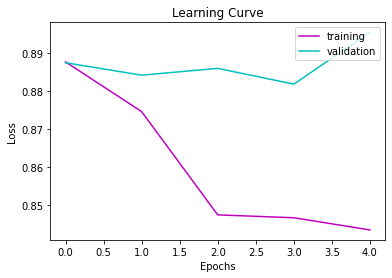

In [ ]:
epochs = np.arange(0, 5).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

[1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


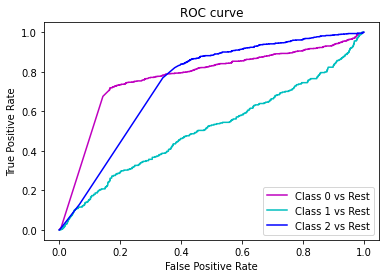

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### <font color='pink'>EXPERIMENTS</font>

### 1: lr = 1e-4, batch size = 16

In [ ]:
num_classes = 3
learning_rate = 0.0001


bert_model = Classifier(num_classes, device)
loss_function = nn.CrossEntropyLoss()
# loss_function.to(device)
optimizer = optim.Adam(bert_model.parameters(), lr=0.0001, weight_decay=1e-4)
bert_model.to(device)
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(bert_model, 5, 16 , 
                                                                                                          loss_function, optimizer,
                                                                                                          train_set, valid_set)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Train batch  705
Train batch  706
Train batch  707
Train batch  708
Train batch  709
Train batch  710
Train batch  711
Train batch  712
Train batch  713
Train batch  714
Train batch  715
Train batch  716
Train batch  717
Train batch  718
Train batch  719
Train batch  720
Train batch  721
Train batch  722
Train batch  723
Train batch  724
Train batch  725
Train batch  726
Train batch  727
Train batch  728
Train batch  729
Train batch  730
Train batch  731
Train batch  732
Train batch  733
Train batch  734
Train batch  735
Train batch  736
Train batch  737
Train batch  738
Train batch  739
Train batch  740
Train batch  741
Train batch  742
Train batch  743
Train batch  744
Train batch  745
Train batch  746
Train batch  747
Train batch  748
Train batch  749
Train batch  750
Train batch  751
Train batch  752
Train batch  753
Train batch  754
Train batch  755
Train batch  756
Train batch  757
Train batch  758
Train batch  759
Train batc

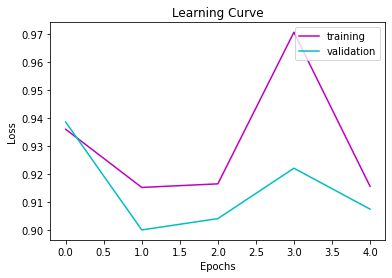

In [ ]:
epochs = np.arange(0, 5).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
y_valid_predictions

In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

[1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


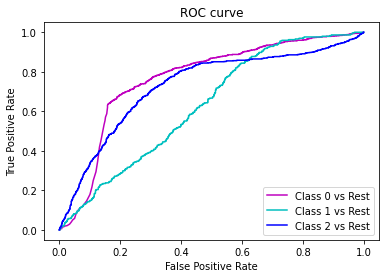

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### 2: lr = 1e-5, batch size = 16

In [ ]:
num_classes = 3
learning_rate = 0.00001


bert_model = Classifier(num_classes, device)
loss_function = nn.CrossEntropyLoss()
# loss_function.to(device)
optimizer = optim.Adam(bert_model.parameters(), lr=0.0001, weight_decay=1e-4)
bert_model.to(device)
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(bert_model, 5, 16 , 
                                                                                                          loss_function, optimizer,
                                                                                                          train_set, valid_set)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Train batch  705
Train batch  706
Train batch  707
Train batch  708
Train batch  709
Train batch  710
Train batch  711
Train batch  712
Train batch  713
Train batch  714
Train batch  715
Train batch  716
Train batch  717
Train batch  718
Train batch  719
Train batch  720
Train batch  721
Train batch  722
Train batch  723
Train batch  724
Train batch  725
Train batch  726
Train batch  727
Train batch  728
Train batch  729
Train batch  730
Train batch  731
Train batch  732
Train batch  733
Train batch  734
Train batch  735
Train batch  736
Train batch  737
Train batch  738
Train batch  739
Train batch  740
Train batch  741
Train batch  742
Train batch  743
Train batch  744
Train batch  745
Train batch  746
Train batch  747
Train batch  748
Train batch  749
Train batch  750
Train batch  751
Train batch  752
Train batch  753
Train batch  754
Train batch  755
Train batch  756
Train batch  757
Train batch  758
Train batch  759
Train batc

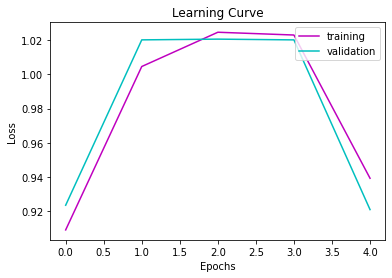

In [ ]:
epochs = np.arange(0, 5).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

[1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


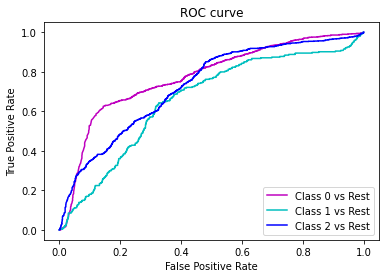

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### 3: 25 tokens, lr = 1e-5, batch size = 16

In [ ]:
num_classes = 3
learning_rate = 0.00001


bert_model = Classifier(num_classes, max_tokens=25)
loss_function = nn.CrossEntropyLoss()
# loss_function.to(device)
optimizer = optim.Adam(bert_model.parameters(), lr=0.0001, weight_decay=1e-4)
bert_model.to(device)
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(bert_model, 5, 16 , 
                                                                                                          loss_function, optimizer,
                                                                                                          train_set, valid_set)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Valid batch  0
Valid batch  100
Epoch   0: Training Loss = 0.96468
Epoch   0: Validation Loss = 1.02064
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Valid batch  0
Valid batch  100
Epoch   1: Training Loss = 1.02205
Epoch   1: Validation Loss = 1.02023
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Valid batch  0
Valid batch  100
Epoch   2: Training Loss = 1.02166
Epoch   2: Validation Loss = 1.02025
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Valid batch  0
V

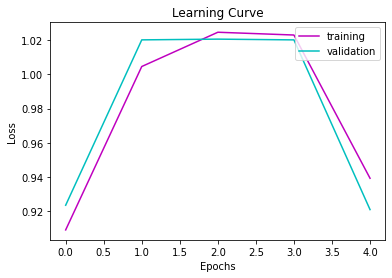

In [ ]:
epochs = np.arange(0, 5).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

[1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


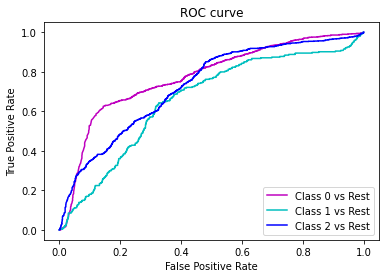

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### 4: 25 tokens, batch size = 8, lr = 1e-5

In [ ]:
num_classes = 3
learning_rate = 0.00001


bert_model = Classifier(num_classes, max_tokens=25)
loss_function = nn.CrossEntropyLoss()
# loss_function.to(device)
optimizer = AdamW(bert_model.parameters(), lr=0.0001, weight_decay=1e-4)
bert_model.to(device)
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(bert_model, 5, 8, 
                                                                                                          loss_function, optimizer,
                                                                                                          train_set, valid_set)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Train batch  1000
Train batch  1100
Train batch  1200
Train batch  1300
Train batch  1400
Train batch  1500
Train batch  1600
Train batch  1700
Train batch  1800
Train batch  1900
Valid batch  0
Valid batch  100
Valid batch  200
Epoch   0: Training Loss = 0.96506
Epoch   0: Validation Loss = 0.92874
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Train batch  1000
Train batch  1100
Train batch  1200
Train batch  1300
Train batch  1400
Train batch  1500
Train batch  1600
Train batch  1700
Train batch  1800
Train batch  1900
Valid batch  0
Valid batch  100
Valid batch  200
Epoch   1: Training Loss = 0.96422
Epoch   1: Validation Loss = 1.02200
Train batch  0
Train batch  100
Train batch  200
Train batch  

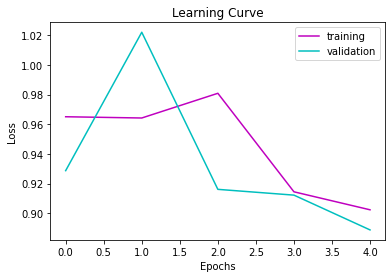

In [ ]:
epochs = np.arange(0, 5).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

[1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


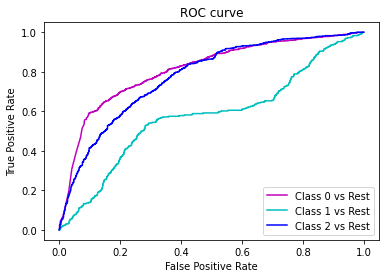

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### 5: 25 tokens batch size = 16, lr = 5e-5, 2,5 min/epoch 

In [ ]:
num_classes = 3
learning_rate = 5e-5


bert_model = Classifier(num_classes, max_tokens=25)
loss_function = nn.CrossEntropyLoss()
loss_function.to(device)
optimizer = AdamW(bert_model.parameters(), lr=0.0001, weight_decay=1e-4)
bert_model.to(device)
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(bert_model, 4, 16, 
                                                                                                          loss_function, optimizer,
                                                                                                          train_set, valid_set)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Valid batch  0
Valid batch  100
Epoch   0: Training Loss = 0.97008
Epoch   0: Validation Loss = 0.93085
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Valid batch  0
Valid batch  100
Epoch   1: Training Loss = 0.91446
Epoch   1: Validation Loss = 0.92308
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Valid batch  0
Valid batch  100
Epoch   2: Training Loss = 0.92037
Epoch   2: Validation Loss = 0.91258
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Valid batch  0
V

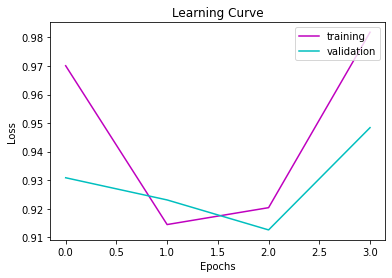

In [ ]:
epochs = np.arange(0, 4).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

[1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


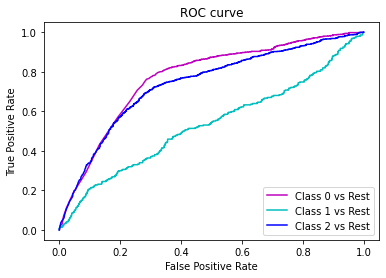

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### 6: 25 tokens, batch size = 32, lr = 5e-5, 3.5 min/epoch

In [ ]:
num_classes = 3
learning_rate = 5e-5


bert_model = Classifier(num_classes, max_tokens=25)
loss_function = nn.CrossEntropyLoss()
loss_function.to(device)
optimizer = AdamW(bert_model.parameters(), lr=0.0001, weight_decay=1e-4)
bert_model.to(device)
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(bert_model, 4, 32, 
                                                                                                          loss_function, optimizer,
                                                                                                          train_set, valid_set)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Valid batch  0
Epoch   0: Training Loss = 0.96485
Epoch   0: Validation Loss = 0.93069
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Valid batch  0
Epoch   1: Training Loss = 0.94190
Epoch   1: Validation Loss = 0.92240
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Valid batch  0
Epoch   2: Training Loss = 0.91963
Epoch   2: Validation Loss = 0.91996
Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Valid batch  0
Epoch   3: Training Loss = 0.91500
Epoch   3: Validation Loss = 0.92783


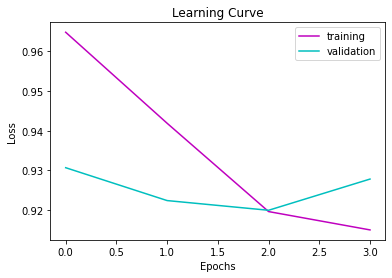

In [ ]:
epochs = np.arange(0, 4).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

[1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


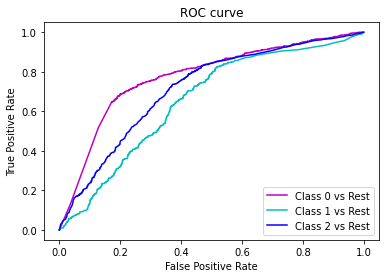

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)